In [1]:
pip install pandas numpy matplotlib scikit-learn xgboost imbalanced-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

### Test Model 4

/opt/anaconda3/envs/is217_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:40:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/is217_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:40:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/is217_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:40:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/is217_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [00:40:43] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_labe

Cross-Validation Accuracy: 0.91613
Test Set Accuracy: 0.91682
Precision: 0.92526
Recall:    0.91482
F1-score:  0.92001
Individual Class Metrics:

Class 0:
  Accuracy:  0.91900
  Precision: 0.90777
  Recall:    0.91900
  F1-score:  0.91335

Class 1:
  Accuracy:  0.91482
  Precision: 0.92526
  Recall:    0.91482
  F1-score:  0.92001
Classification Report:
              precision    recall  f1-score   support

           0    0.90777   0.91900   0.91335      4284
           1    0.92526   0.91482   0.92001      4696

    accuracy                        0.91682      8980
   macro avg    0.91652   0.91691   0.91668      8980
weighted avg    0.91692   0.91682   0.91683      8980

Macro Accuracy: 0.91691
Weighted Accuracy: 0.91682
Top 20 Most Important Features:
                 Feature  Importance
1562                said    0.160829
828                image    0.080444
1933  washington reuters    0.040793
829               images    0.034735
790              hillary    0.027804
500         

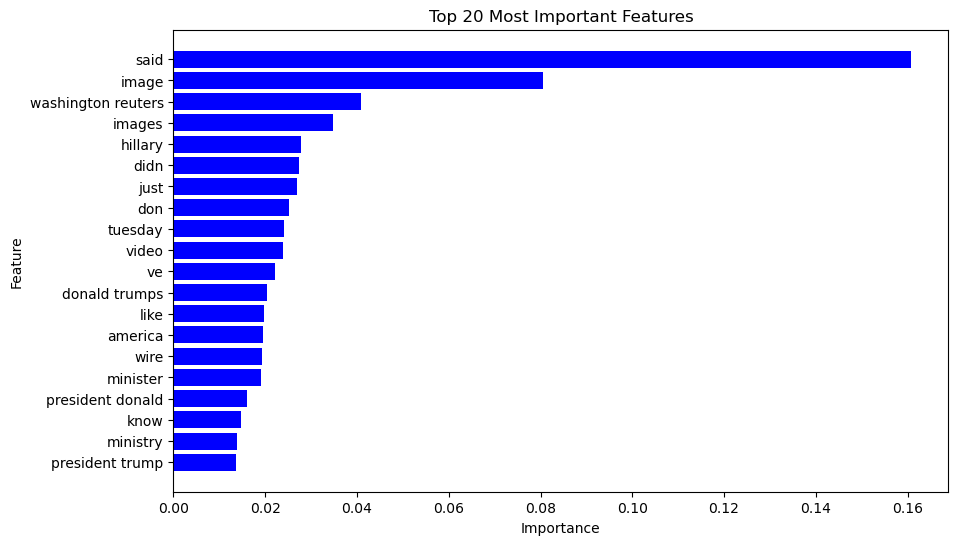

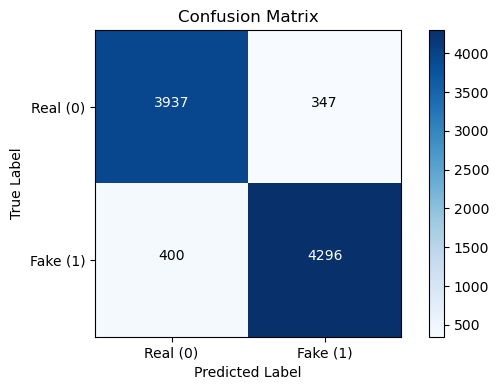

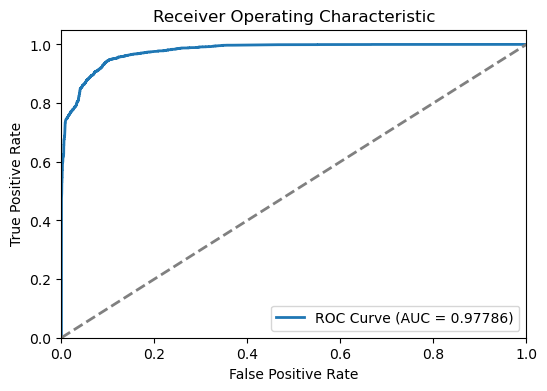

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# -------------------------------
# 1. Load and Prepare the Dataset
# -------------------------------

fake_path = "../data/Fake.csv"
true_path = "../data/True.csv"

# Read CSVs
df_fake = pd.read_csv(fake_path)
df_real = pd.read_csv(true_path)

# Drop unwanted columns: subject and date
df_fake.drop(columns=['subject', 'date'], inplace=True)
df_real.drop(columns=['subject', 'date'], inplace=True)

# Assign labels: 1 for fake news, 0 for real news
df_fake['label'] = 1
df_real['label'] = 0

# Combine title and text columns into a single 'text' column
df_fake['text'] = df_fake['title'] + " " + df_fake['text']
df_real['text'] = df_real['title'] + " " + df_real['text']

# Drop the original title column
df_fake.drop(columns=['title'], inplace=True)
df_real.drop(columns=['title'], inplace=True)

# Concatenate both datasets and shuffle
df = pd.concat([df_fake, df_real], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# -------------------------------
# Clean the Text Data
# -------------------------------
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)      # Remove brackets
    text = re.sub(r'http\S+', '', text)        # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)        # Remove punctuation
    text = re.sub(r'\d+', '', text)            # Remove numbers
    return text

# Create a cleaned text column
df['clean_text'] = df['text'].apply(clean_text)

# -------------------------------
# 2. Train-Test Split
# -------------------------------
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------------
# 3. Convert Text Data to TF-IDF Features
# -------------------------------
vectorizer = TfidfVectorizer(
    max_features=2000, # Capture more meaningful words
    ngram_range=(1, 3),
    stop_words='english',
    max_df=0.85, # Allow slightly more frequent words
    min_df=5, # Capture rarer words
    norm='l2'
)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Get feature names
feature_names = np.array(vectorizer.get_feature_names_out())

# Identify indices of unwanted features
exclude_words = {"reuters"}
valid_indices = [i for i, word in enumerate(feature_names) if word not in exclude_words]

# Filter out unwanted features
X_train_tfidf = X_train_tfidf[:, valid_indices]
X_test_tfidf = X_test_tfidf[:, valid_indices]

# Update feature names
filtered_feature_names = feature_names[valid_indices]

# -------------------------------
# 4. Handle Class Imbalance using SMOTE
# -------------------------------
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

# -------------------------------
# 5. Train XGBoost Model
# -------------------------------
model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=3.0,
    reg_lambda=6.0,
    min_child_weight=3,
    use_label_encoder=False,
    eval_metric='logloss'
)



model.fit(X_train_balanced, y_train_balanced)

# -------------------------------
# 6. Cross-Validation
# -------------------------------
cv_scores = cross_val_score(model, X_train_balanced, y_train_balanced, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {np.mean(cv_scores):.5f}")

# -------------------------------
# 7. Evaluate the Model
# -------------------------------
y_pred = model.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Test Set Accuracy: {accuracy:.5f}")
print(f"Precision: {precision:.5f}")
print(f"Recall:    {recall:.5f}")
print(f"F1-score:  {f1:.5f}")


# Compute per-class metrics using average=None
precision_per_class = precision_score(y_test, y_pred, average=None)
recall_per_class = recall_score(y_test, y_pred, average=None)
f1_per_class = f1_score(y_test, y_pred, average=None)
cm = confusion_matrix(y_test, y_pred)
classes = np.unique(y_test)
print("Individual Class Metrics:")
for idx, cls in enumerate(classes):
    # Per-class accuracy is the fraction of correct predictions for that class.
    class_accuracy = cm[idx, idx] / cm[idx].sum()
    print(f"\nClass {cls}:")
    print(f"  Accuracy:  {class_accuracy:.5f}")
    print(f"  Precision: {precision_per_class[idx]:.5f}")
    print(f"  Recall:    {recall_per_class[idx]:.5f}")
    print(f"  F1-score:  {f1_per_class[idx]:.5f}")

print("Classification Report:")
print(classification_report(y_test, y_pred, digits=5))

# Compute per-class accuracy
acc_class0 = cm[0, 0] / np.sum(cm[0, :])
acc_class1 = cm[1, 1] / np.sum(cm[1, :])
macro_accuracy = (acc_class0 + acc_class1) / 2

# Overall accuracy (weighted by class support)
weighted_accuracy = (acc_class0 * (cm[0, :].sum() / cm.sum())) + (acc_class1 * (cm[1, :].sum() / cm.sum()))

print("Macro Accuracy: {:.5f}".format(macro_accuracy))
print("Weighted Accuracy: {:.5f}".format(weighted_accuracy))


# -------------------------------
# 8. Feature Importance
# -------------------------------
importance = model.feature_importances_
importance_df = pd.DataFrame({'Feature': filtered_feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 20 most important features
print("Top 20 Most Important Features:")
print(importance_df.head(20))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20], color='blue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features')
plt.gca().invert_yaxis()
plt.show()

# -------------------------------
# 9. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
classes = ["Real (0)", "Fake (1)"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# -------------------------------
# 10. ROC Curve
# -------------------------------
y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, lw=2, label=f'ROC Curve (AUC = {roc_auc:.5f})')
plt.plot([0, 1], [0, 1], lw=2, linestyle='--', color='gray')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [4]:
fake_path = "../data/Fake.csv"
true_path = "../data/True.csv"

# Read CSVs
df_fake = pd.read_csv(fake_path)
df_real = pd.read_csv(true_path)

print(df_fake['title'][0])
print(df_fake['text'][0])

 Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this d

In [5]:
df_real
print(df_real['title'][0])
print(df_real['text'][0])

As U.S. budget fight looms, Republicans flip their fiscal script
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-

In [6]:
#Testing on Model 4
# Real news article 
def predict_news(article_text):

    # Transform the input text into TF-IDF feature space
    news_vector = vectorizer.transform([article_text])

    # Apply the same feature filtering used in training
    news_vector = news_vector[:, valid_indices]  # Use valid_indices from training

    # Predict using the trained XGBoost model
    prediction = model.predict(news_vector)[0]

    # Get the prediction probability (confidence score)
    predicted_proba = model.predict_proba(news_vector)[0][1]  # Probability of being REAL

    # Map predictions to human-readable labels
    label_map = {1: "FAKE", 0: "REAL"}

    # Print results
    print(f"Predicted Class: {prediction} => {label_map[prediction]}")
    print(f"Confidence (Probability for 'FAKE'): {predicted_proba:.4f}")


# -------------------------------
# 📌 Example: Testing on a Sample News Article
# -------------------------------

# Replace this text with any article you want to classify
news_article = """
Apple announced a new line of products at its annual event. 
The company said that these new devices will significantly enhance user productivity and provide cutting-edge features for daily use.
"""

# Run the prediction function
predict_news(news_article)


Predicted Class: 0 => REAL
Confidence (Probability for 'FAKE'): 0.1731


In [7]:
# Real news article 
def predict_news(article_text):

    # Transform the input text into TF-IDF feature space
    news_vector = vectorizer.transform([article_text])

    # Apply the same feature filtering used in training
    news_vector = news_vector[:, valid_indices]  # Use valid_indices from training

    # Predict using the trained XGBoost model
    prediction = model.predict(news_vector)[0]

    # Get the prediction probability (confidence score)
    predicted_proba = model.predict_proba(news_vector)[0][1]  # Probability of being REAL

    # Map predictions to human-readable labels
    label_map = {1: "FAKE", 0: "REAL"}

    # Print results
    print(f"Predicted Class: {prediction} => {label_map[prediction]}")
    print(f"Confidence (Probability for 'FAKE'): {predicted_proba:.4f}")

# -------------------------------
# 📌 Example: Testing on a Sample News Article
# -------------------------------

# Replace this text with any article you want to classify
news_article = """
Gaza’s fragile ceasefire shattered early Tuesday as Israel carried out deadly strikes across the enclave and Israeli Prime Minister Benjamin Netanyahu vowed to use “increasing military strength” against Hamas.

The overnight bombardments struck multiple locations across Gaza and were the most extensive since a months-long ceasefire came into effect, with Israel’s Defense Minister Israel Katz declaring: “Tonight we returned to fighting in Gaza.”

The ceasefire deal between Israel and Hamas was already hanging in the balance with phase one ending more than two weeks ago and all sides at loggerheads over a path forward that might see remaining Israeli hostages freed and a permanent peace secured.

Israel’s military and security agency said they were “currently conducting extensive strikes” on Hamas targets in Gaza. In response, Hamas accused Netanyahu of deciding to overturn the ceasefire agreement, and “putting the captives in Gaza at risk of an unknown fate.”

At least 210 people have been killed and hundreds wounded in the new wave of Israeli strikes, according to the Palestinian ministry of health in Gaza.

The Civil Defense in Gaza said a number people were “trapped under the rubble of homes that were bombed in various areas” of the enclave. CNN stringers in Gaza reported the sounds of strikes in multiple locations, including Gaza City, Khan Younis and Deir al-Balah.

Videos obtained by CNN showed scenes of panic and chaos across Gaza as families desperately rushed wounded loved ones to hospital and rescue workers transported patients in ambulances or on stretchers.

Many of the wounded were covered with bloodstained blankets, while others had their limbs wrapped in bloodied bandages.

The images showed several young children killed by the strikes.

Deaths and injuries, including of children, have been reported at hospitals ranging from the northern end of the strip to its southern tip more than 30 kilometers (18 miles) away, including Al-Awda hospital in Tal Al-Zaatar, northern Gaza; Al-Awda hospital in Nuseirat, central Gaza; and Nasser hospital in the southern city of Khan Younis.

Several hospitals said the casualties were due to civilian homes being hit by the strikes.
"""

# Run the prediction function
predict_news(news_article)


Predicted Class: 0 => REAL
Confidence (Probability for 'FAKE'): 0.1576


In [8]:
# Fake news article
def predict_news(article_text):

    # Transform the input text into TF-IDF feature space
    news_vector = vectorizer.transform([article_text])

    # Apply the same feature filtering used in training
    news_vector = news_vector[:, valid_indices]  # Use valid_indices from training

    # Predict using the trained XGBoost model
    prediction = model.predict(news_vector)[0]

    # Get the prediction probability (confidence score)
    predicted_proba = model.predict_proba(news_vector)[0][1]  # Probability of being REAL

    # Map predictions to human-readable labels
    label_map = {1: "FAKE", 0: "REAL"}

    # Print results
    print(f"Predicted Class: {prediction} => {label_map[prediction]}")
    print(f"Confidence (Probability for 'FAKE'): {predicted_proba:.4f}")

# -------------------------------
# 📌 Example: Testing on a Sample News Article
# -------------------------------

# Replace this text with any article you want to classify

news_article = """
Scientists Discover a Hidden City Beneath the Sahara Desert!

In an astonishing discovery, a team of archaeologists from an undisclosed research institute has reportedly uncovered the ruins of an ancient civilization beneath the Sahara Desert. Using ground-penetrating radar technology, researchers claim to have identified an extensive network of tunnels, structures, and artifacts dating back over 10,000 years—predating the Egyptian pyramids.

Lead scientist Dr. Marcus Langley stated, "This civilization appears to have been highly advanced, with evidence of an intricate water system and remnants of metal tools that do not match any known historical period."

Satellite images allegedly reveal massive underground chambers, leading to speculation that this lost city may be the true origin of many myths about lost civilizations. However, governments and scientific organizations remain skeptical, urging further investigation before drawing conclusions.

Critics argue that no verifiable evidence has been released, and some experts believe this may be an elaborate hoax or a misinterpretation of natural formations. Nevertheless, conspiracy theorists are already calling this the "Atlantis of the Sahara."

What else could be hidden beneath Earth's shifting sands?
"""

# Run the prediction function
predict_news(news_article)


Predicted Class: 1 => FAKE
Confidence (Probability for 'FAKE'): 0.7917


In [9]:
#DataSet's Real news article
def predict_news(article_text):

    # Transform the input text into TF-IDF feature space
    news_vector = vectorizer.transform([article_text])

    # Apply the same feature filtering used in training
    news_vector = news_vector[:, valid_indices]  # Use valid_indices from training

    # Predict using the trained XGBoost model
    prediction = model.predict(news_vector)[0]


    # Get the prediction probability (confidence score)
    predicted_proba = model.predict_proba(news_vector)[0][1]  # Probability of being REAL

    # Map predictions to human-readable labels
    label_map = {1: "FAKE", 0: "REAL"}

    # Print results
    print(f"Predicted Class: {prediction} => {label_map[prediction]}")
    print(f"Confidence (Probability for 'FAKE'): {predicted_proba:.4f}")

# -------------------------------
# 📌 Example: Testing on a Sample News Article
# -------------------------------

# Replace this text with any article you want to classify


news_article = """
WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support education, scientific research, infrastructure, public health and environmental protection. “The (Trump) administration has already been willing to say: ‘We’re going to increase non-defense discretionary spending ... by about 7 percent,’” Meadows, chairman of the small but influential House Freedom Caucus, said on the program. “Now, Democrats are saying that’s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I don’t see where the rationale is. ... Eventually you run out of other people’s money,” he said. Meadows was among Republicans who voted in late December for their party’s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. “It’s interesting to hear Mark talk about fiscal responsibility,” Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. “This is one of the least ... fiscally responsible bills we’ve ever seen passed in the history of the House of Representatives. I think we’re going to be paying for this for many, many years to come,” Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or “entitlement reform,” as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, “entitlement” programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryan’s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the “Dreamers,” people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. “We need to do DACA clean,” she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid. As U.S. budget fight looms, Republicans flip their fiscal script
"""

# Run the prediction function
predict_news(news_article)


Predicted Class: 0 => REAL
Confidence (Probability for 'FAKE'): 0.2155


In [10]:
#DataSet's Fake news article 
def predict_news(article_text):

    # Transform the input text into TF-IDF feature space
    news_vector = vectorizer.transform([article_text])

    # Apply the same feature filtering used in training
    news_vector = news_vector[:, valid_indices]  # Use valid_indices from training

    # Predict using the trained XGBoost model
    prediction = model.predict(news_vector)[0]

    # Get the prediction probability (confidence score)
    predicted_proba = model.predict_proba(news_vector)[0][1]  # Probability of being REAL

    # Map predictions to human-readable labels
    label_map = {1: "FAKE", 0: "REAL"}

    # Print results
    print(f"Predicted Class: {prediction} => {label_map[prediction]}")
    print(f"Confidence (Probability for 'FAKE'): {predicted_proba:.4f}")

# -------------------------------
# 📌 Example: Testing on a Sample News Article
# -------------------------------

# Replace this text with any article you want to classify


news_article = """
Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t even allow him to rise above the gutter long enough to wish the American citizens a happy new year!  Bishop Talbert Swan (@TalbertSwan) December 31, 2017no one likes you  Calvin (@calvinstowell) December 31, 2017Your impeachment would make 2018 a great year for America, but I ll also accept regaining control of Congress.  Miranda Yaver (@mirandayaver) December 31, 2017Do you hear yourself talk? When you have to include that many people that hate you you have to wonder? Why do the they all hate me?  Alan Sandoval (@AlanSandoval13) December 31, 2017Who uses the word Haters in a New Years wish??  Marlene (@marlene399) December 31, 2017You can t just say happy new year?  Koren pollitt (@Korencarpenter) December 31, 2017Here s Trump s New Year s Eve tweet from 2016.Happy New Year to all, including to my many enemies and those who have fought me and lost so badly they just don t know what to do. Love!  Donald J. Trump (@realDonaldTrump) December 31, 2016This is nothing new for Trump. He s been doing this for years.Trump has directed messages to his  enemies  and  haters  for New Year s, Easter, Thanksgiving, and the anniversary of 9/11. pic.twitter.com/4FPAe2KypA  Daniel Dale (@ddale8) December 31, 2017Trump s holiday tweets are clearly not presidential.How long did he work at Hallmark before becoming President?  Steven Goodine (@SGoodine) December 31, 2017He s always been like this . . . the only difference is that in the last few years, his filter has been breaking down.  Roy Schulze (@thbthttt) December 31, 2017Who, apart from a teenager uses the term haters?  Wendy (@WendyWhistles) December 31, 2017he s a fucking 5 year old  Who Knows (@rainyday80) December 31, 2017So, to all the people who voted for this a hole thinking he would change once he got into power, you were wrong! 70-year-old men don t change and now he s a year older.Photo by Andrew Burton/Getty Images.

Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing
"""

# Run the prediction function
predict_news(news_article)


Predicted Class: 1 => FAKE
Confidence (Probability for 'FAKE'): 0.8779
